# Retinal Segmentation

Project was implemented with three approaches: classic image processing techniques, a basic level classifier and a deep learning network.

## Classical image processing techniques

Opis podejścia

In [50]:
from IPython.display import display
import PIL
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img
from numpy import asarray
import skimage
from skimage.exposure import equalize_hist
from skimage.filters import unsharp_mask
from skimage.morphology import erosion, disk, square, dilation, closing
import scipy
from skimage import data, filters, exposure, feature
from skimage.color import rgb2hsv, hsv2rgb, rgb2gray
from skimage.filters.edges import convolve
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from scipy.stats import gmean
from statistics import mean
from PIL import Image, ImageChops
import random

## Pozyskanie przykładowych obrazów

In [55]:
import os

data_dir, target_dir = \
        f"{os.getcwd()[:-4]}\\resource\\images", \
        f"{os.getcwd()[:-4]}\\resource\\labels"

input_img_paths = sorted(
    [
        os.path.join(data_dir, fname)
        for fname in os.listdir(data_dir)
        if fname.endswith(".ppm")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".ppm") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:2], target_img_paths[:2]):
    print(input_path, "|", target_path)

Number of samples: 20
C:\Users\Alex\PycharmProjects\retinal-segmentation\retinal_segmentation\resource\images\im0001.ppm | C:\Users\Alex\PycharmProjects\retinal-segmentation\retinal_segmentation\resource\labels\im0001.ah.ppm
C:\Users\Alex\PycharmProjects\retinal-segmentation\retinal_segmentation\resource\images\im0002.ppm | C:\Users\Alex\PycharmProjects\retinal-segmentation\retinal_segmentation\resource\labels\im0002.ah.ppm


## Przykładowy obraz

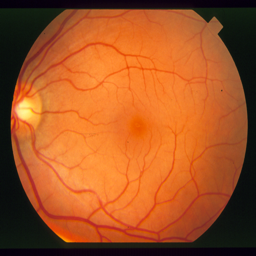

In [56]:
i = 6
image = Image.open(input_img_paths[i])
display(image.resize((256, 256)))

## Przykładowy oczeikwany wynik

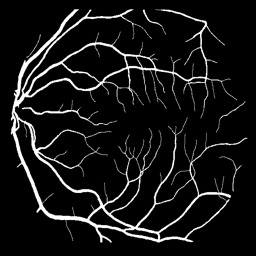

In [57]:
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
display(img.resize((256, 256)))

We've created two functions with different configurations of image processing techniques

In [58]:
def morph_1(img):
    inv = ImageChops.invert(img)

    img = asarray(inv)
    img = rgb2gray(img)

    img = equalize_hist(img)   # normalize histogram

    img = unsharp_mask(img, radius=6, amount=3)   # sharpen

    img =  dilation(skimage.feature.canny(img, sigma=3.5))

    img = closing(img, disk(3))

    return img

def morph_2(img):
    img = asarray(img)
    img = rgb2gray(img)

    img2 = equalize_hist(img)   # normalize histogram

    x = 4
    kernel = np.ones((x,x),np.uint8)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

    img = filters.sobel(img) #  sobel

    x = 8
    K = np.ones([x,x])
    K = K / sum(K)
    img = convolve(img, K)

    x = 4
    kernel = np.ones((x,x),np.uint8)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)

    img = unsharp_mask(img, radius=64, amount=8)   # sharpen
    return img

In [59]:
stats = ['Accuracy', 'Sensitivity', 'Specificity', 'Geometric']

def binary_mask(img, thresh=0.1):
    img = img.copy()
    img[img[:, :] > img * thresh] = 1
    img[img[:, :] < img * thresh] = 0
    return erosion(img, disk(2))

def get_statistics(img, mask):
    (w, h) = img.shape

    tp, fp, fn, tn = 0, 0, 0, 0
    for x in range(w):
        for y in range(h):
            if (img[x, y]):
                if (mask[x, y]):
                    tp += 1
                else:
                    fp += 1
            else:
                if (mask[x, y]):
                    fn += 1
                else:
                    tn += 1

    return tp, fp, fn, tn

def get_metrics(img, mask, thresh=0.1):
    img_bool = img > thresh
    mask_bool = mask > thresh

    tp, fp, fn, tn = get_statistics(img_bool, mask_bool)

    accuracy = (tp + tn) / (tn + fn + tp + fp)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    geometric = gmean([sensitivity, specificity])

    return accuracy, sensitivity, specificity, geometric

def print_stats(stats, i):
    print(f"Image no. {i}")
    print(f"Accuracy: {stats[0]}")
    print(f"Sensitivity: {stats[1]}")
    print(f"Specificity: {stats[2]}")
    print(f"Geometric: {stats[3]}")

Segmented vessels:


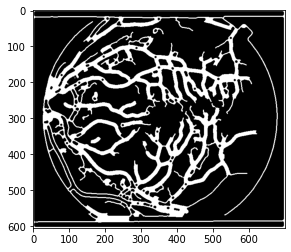

In [60]:
print("Segmented vessels:")
img = morph_1(Image.open(input_img_paths[i]))
plt.imshow(img, cmap='gray');

Image no. 6
Accuracy: 0.890344746162928
Sensitivity: 0.37020728617122917
Specificity: 0.9570618669309505
Geometric: 0.5952405198358705


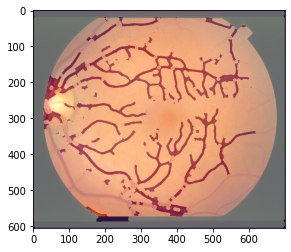

In [61]:
mask = binary_mask(img)

plt.imshow(load_img(input_img_paths[i]))
plt.imshow(img * mask, cmap='Purples', alpha=0.4)

stats = get_metrics(asarray(Image.open(target_img_paths[i])), mask)
print_stats(stats, i)

Segmented vessels:


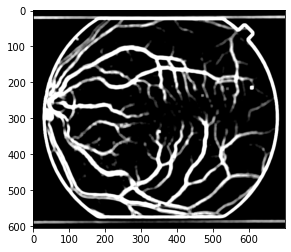

In [62]:
img = morph_2(Image.open(input_img_paths[i]))

print("Segmented vessels:")
plt.imshow(img, cmap='gray');

As we can see, the generated picture is much more blurred and still contains the round outline of the eye, which negatively affects the metrics. We can also note that the specificity metric is higher for this method, as it finds smaller vein fragments than the previous algorithm. This however adds artifacts and random noise to the image.

Image no. 6
Accuracy: 0.847582054309327
Sensitivity: 0.33539130060663425
Specificity: 0.9916527495401297
Geometric: 0.5767076429339297


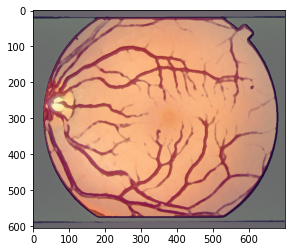

In [63]:
mask = binary_mask(img)


plt.imshow(load_img(input_img_paths[i]))
plt.imshow(img * mask, cmap='Purples', alpha=0.4)

stats = get_metrics(asarray(Image.open(target_img_paths[i])), mask)
print_stats(stats, i)

Experiments done on several images for computing average metrics

In [64]:
imgs = random.sample(range(20), 10)
history1 = []
history2 = []

for i in imgs:
    img = Image.open(input_img_paths[i])
    vessels1 = morph_1(img)
    vessels2 = morph_2(img)

    mask1 = binary_mask(vessels1)
    mask2 = binary_mask(vessels2)

    stats1 = get_metrics(asarray(Image.open(target_img_paths[i])), mask1)
    stats2 = get_metrics(asarray(Image.open(target_img_paths[i])), mask2)

    history1.append((stats1))
    history2.append((stats2))

print("Method 1:")
for i, stat in enumerate(stats):
    print(f"  {stat}: {mean([x[i] for x in history1])}")
print('')
print("Method 2:")
for i, stat in enumerate(stats):
    print(f"  {stat}: {mean([x[i] for x in history2])}")

Method 1:
  0.847582054309327: 0.8900316410861866
  0.33539130060663425: 0.34960949132925034
  0.9916527495401297: 0.9524342641930537
  0.5767076429339297: 0.5706713362470828

Method 2:
  0.847582054309327: 0.8309884297520661
  0.33539130060663425: 0.2842237894371459
  0.9916527495401297: 0.9758267634499254
  0.5767076429339297: 0.5237255553159255


## Basic level classifier

In [122]:
from retinal_segmentation.basic_level_classifier.knn import \
    load_sliced_images, get_input_features, get_target_vals, init_knn_classifier
from retinal_segmentation.utils.data_loader import get_image_paths, load_image
from sklearn.model_selection import train_test_split
from scipy.stats import gmean
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [68]:
slice_size = 15

data_images, target_images = load_sliced_images(data_dir, target_dir, slice_size=slice_size)

In [69]:
train_data_images, test_data_images, train_target_images, test_target_images = \
        train_test_split(data_images, target_images, test_size=0.3, random_state=42)

In [70]:
train_data, train_target = get_input_features(train_data_images), get_target_vals(train_target_images)
test_data, test_target = get_input_features(test_data_images), get_target_vals(test_target_images)


In [92]:
classifier = init_knn_classifier(train_data, train_target)

KNN experiment

In [93]:
j = 300000
predictions = classifier.predict(test_data[0:j])

In [ ]:


tp, fp, fn, tn = 0, 0, 0, 0
for pred, targ in zip(predictions, test_target[:j]):
    if pred:
        if targ:
            tp += 1
        else:
            fp += 1
    else:
        if targ:
            fn += 1
        else:
            tn += 1

accuracy = (tp + tn) / (tn + fn + tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (fp + tn)
geometric = float(gmean([sensitivity, specificity]))

stats = [accuracy, sensitivity, specificity, geometric]

stat_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Geometric']
for i, name in enumerate(stat_names):
    print(f"{name}: {stats[i]}")

Show predicted vein

1.0


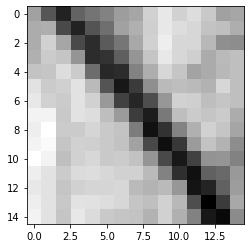

In [116]:
j, s = 0, 0
shift = 33
while predictions[j] != 1 or s < shift:
    j += 1
    s += 1

img = test_data[j]
m = np.sqrt(img.size).astype('int32')
img = img.reshape((m, m))
print(predictions[j])
plt.imshow(img, cmap='gray')

Creating a mask from slice prediction of an image

In [127]:
i = 9
input_img = np.asarray(load_image(get_image_paths(data_dir)[i]))
input_slices = get_input_features(data_images[256*256*(i-1):256*256*i])
target_img = np.asarray(load_image(get_image_paths(target_dir)[i]))

predicted_vector = classifier.predict(input_slices)

In [128]:
np.sum(predicted_vector)

4994.0

In [129]:
predicted_vector.shape

(65536,)

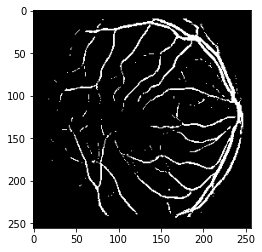

In [130]:
m = 256
predicted_image = np.zeros((m, m))

i = 0
for x in range(m):
    for y in range(m):
        predicted_image[x, y] = predicted_vector[i]
        i += 1
plt.imshow(predicted_image, cmap="gray")

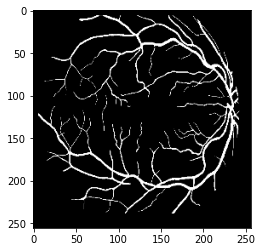

In [131]:
plt.imshow(cv2.resize(target_img, (256,256)), cmap='gray')

Text(0.5, 0.92, 'Blood Vessels Segmentation')

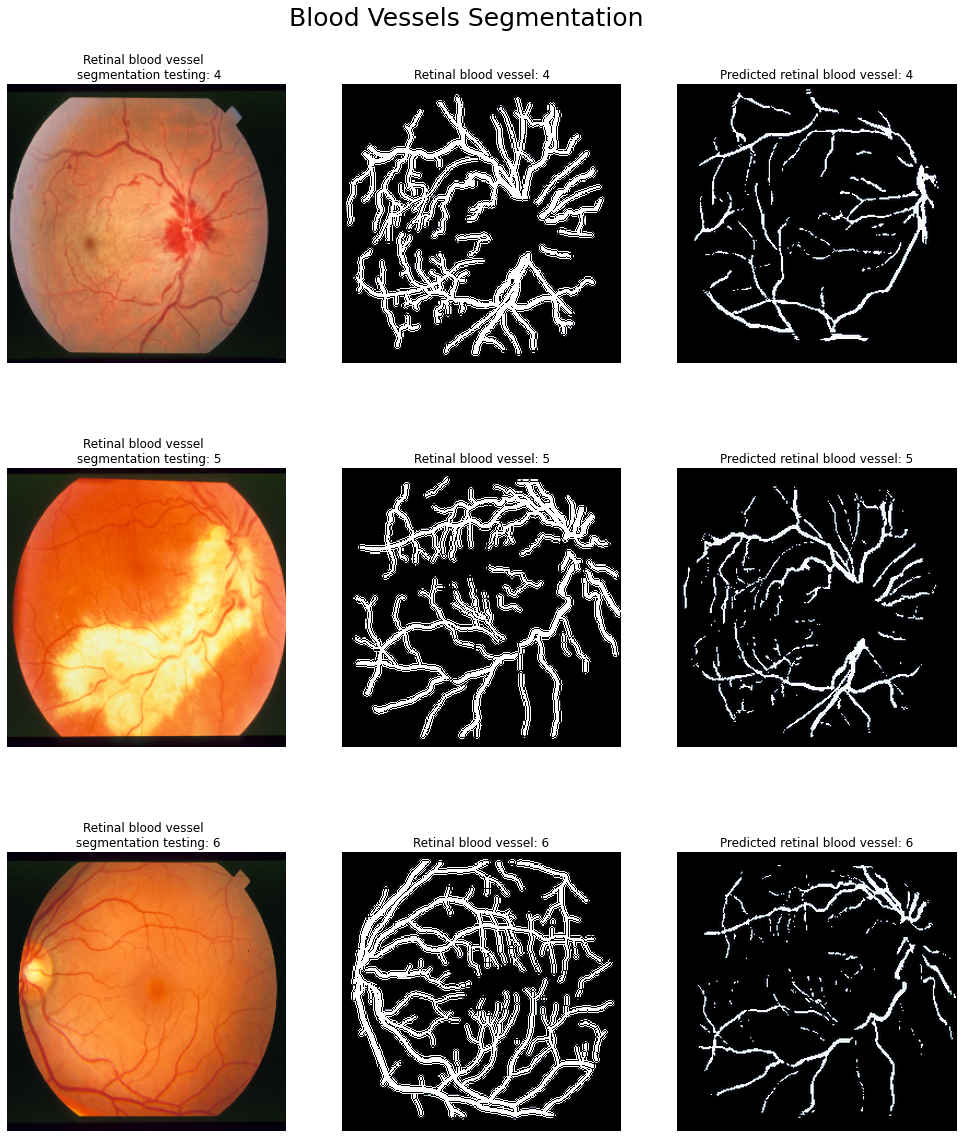

In [133]:
fig, axes = plt.subplots(3, 3, figsize = (17,20))
[c_ax.axis('off') for c_ax in axes.flatten()]

for idx, (img_ax, mask_ax, mask_pred_ax) in zip(range(4, 10), axes):

    shape = (256,256)
    input_img = np.asarray(load_image(get_image_paths(data_dir)[idx]))
    input_slices = get_input_features(data_images[256*256*(idx-1):256*256*idx])
    target_img = np.asarray(load_image(get_image_paths(target_dir)[idx]))

    predicted_vector = classifier.predict(input_slices)

    m = 256
    predicted_image = np.zeros((m, m))

    i = 0
    for x in range(m):
        for y in range(m):
            predicted_image[x, y] = predicted_vector[i]
            i += 1

    img_ax.imshow(np.clip(cv2.resize(input_img, shape), 0, 255))
    mask_ax.imshow(cv2.resize(target_img, shape), cmap = 'bone',
                   vmin = 0, vmax = 1,
                   interpolation = 'lanczos')
    mask_pred_ax.imshow(predicted_image, cmap = 'bone',
                   vmin = 0, vmax = 1,
                   interpolation = 'lanczos')

    img_ax.set_title(f'Retinal blood vessel  \n segmentation testing: {idx}')
    mask_ax.set_title(f'Retinal blood vessel: {idx}')
    mask_pred_ax.set_title(f'Predicted retinal blood vessel: {idx}')
fig.suptitle("Blood Vessels Segmentation", y=0.92, fontsize=25)

## Deep Learning U-net Classifier

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [ ]:
class VesselDataset(Dataset):
    def __init__(self, root_dir, im_transforms, m_transforms):
        self.root_dir = root_dir
        self.im_transforms = im_transforms
        self.m_transforms = m_transforms
        self.images = data[1:][::2]
        self.masks = data[::2]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        image = np.array(image, dtype=np.uint8)

        mask = Image.open(self.masks[idx])
        mask = np.array(mask, dtype=np.uint8)

        image = self.im_transforms(image)
        mask = self.m_transforms(mask)

        return image, mask

In [ ]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))


class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_classes,1)#,1


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        out = torch.sigmoid(out)

        return out

model = UNet(n_classes=1).cuda()

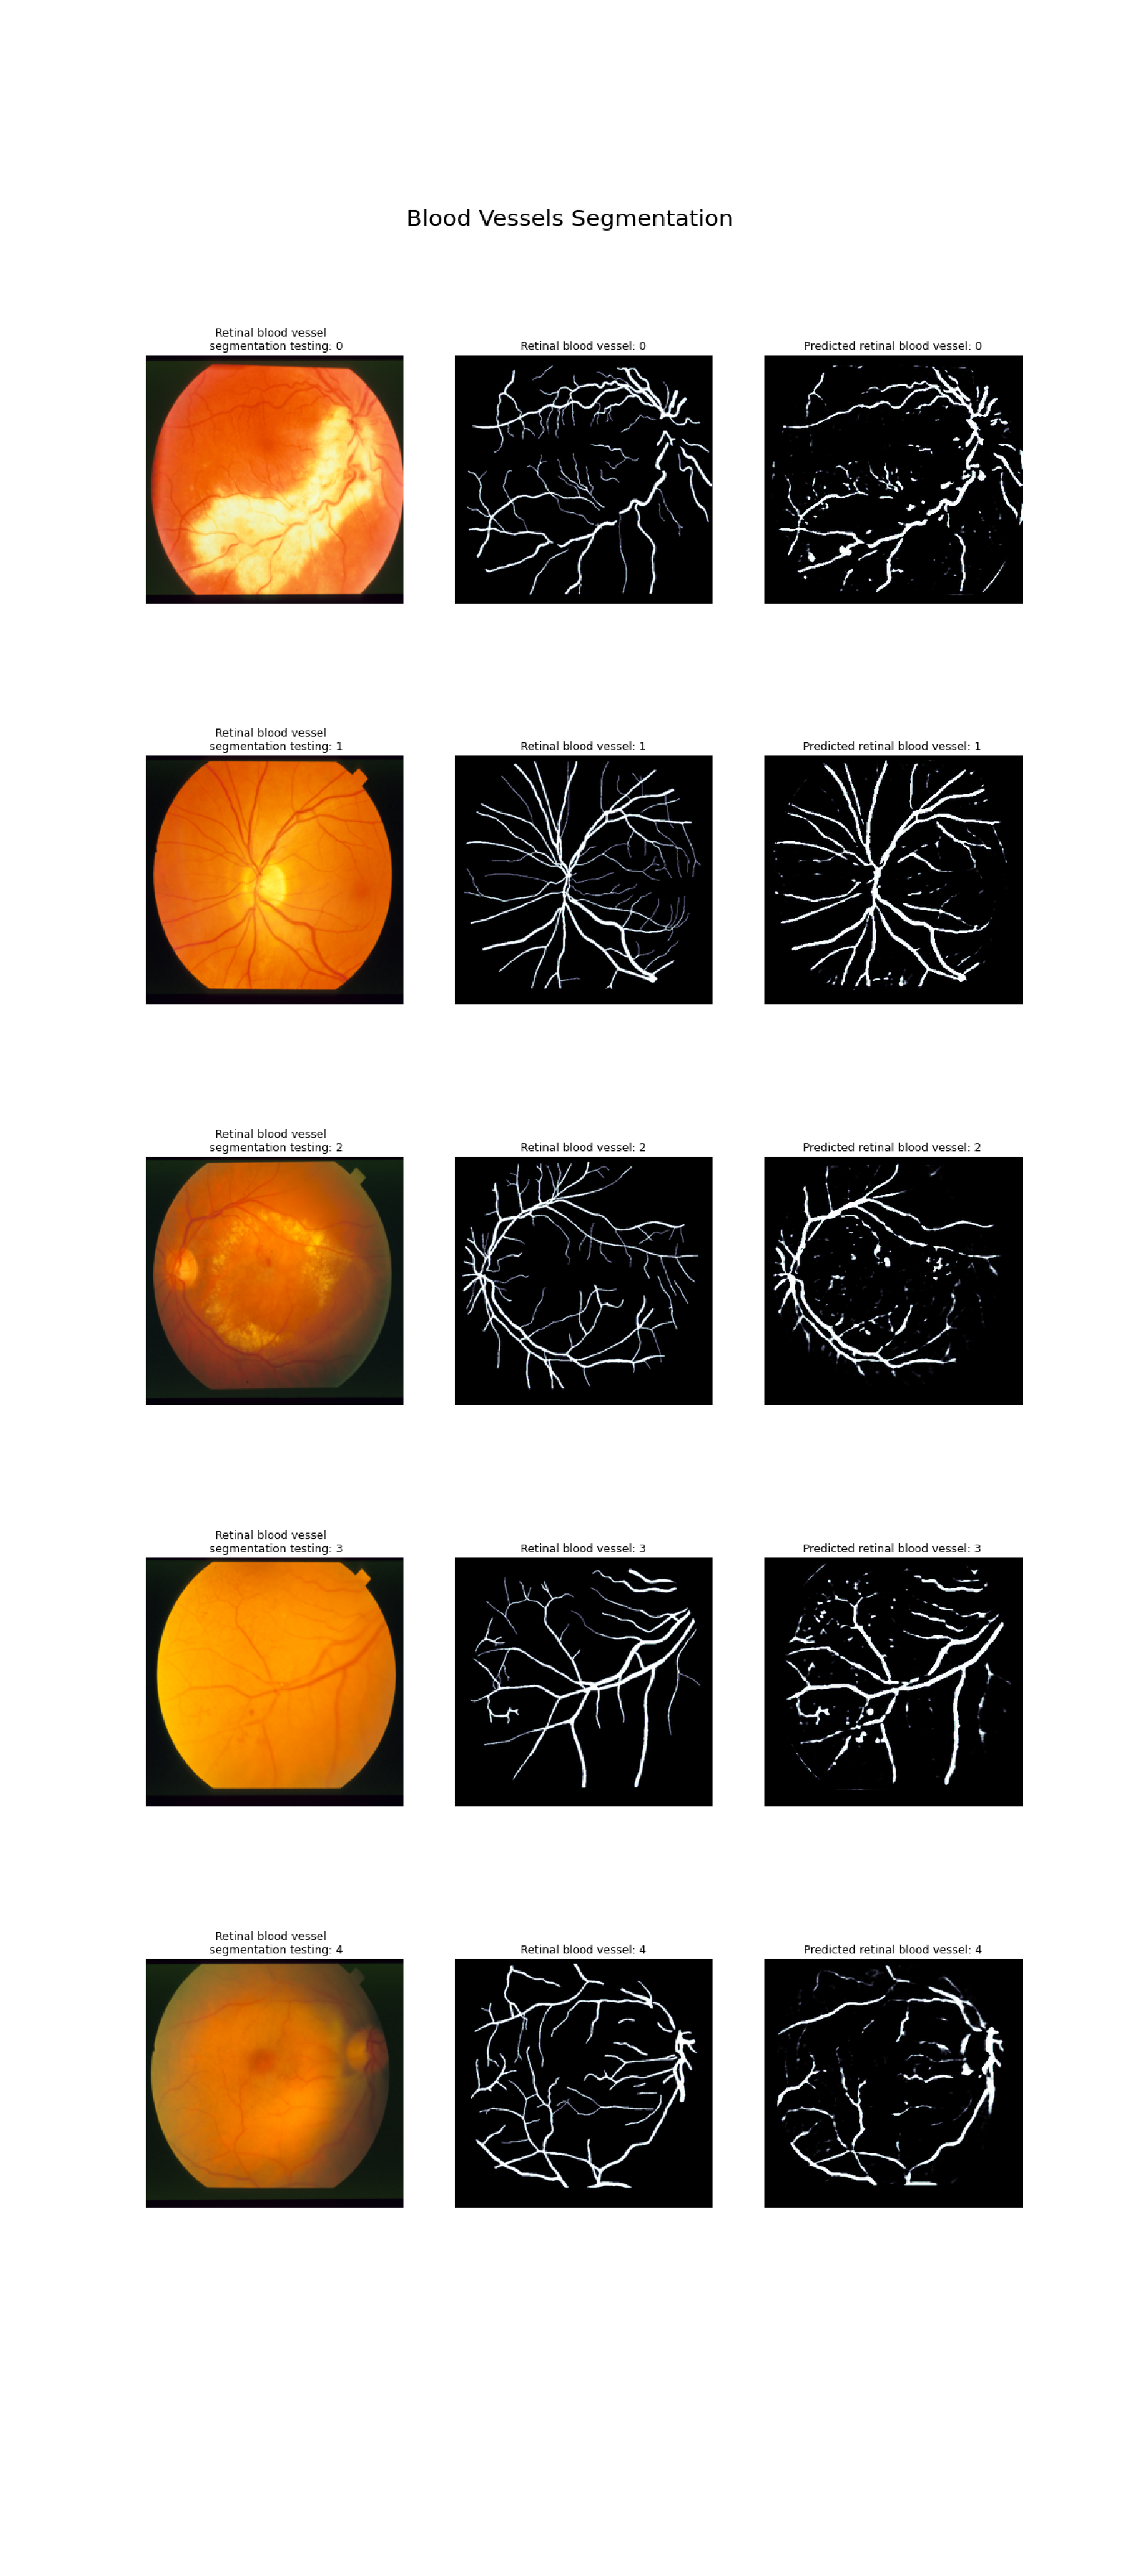

In [66]:
import matplotlib.image as mpimg

img = mpimg.imread('model_testing.png')
plt.figure(figsize = (30,70))
plt.imshow(img, interpolation='nearest' , aspect='auto')
plt.axis('off')
plt.show()